In [1]:
import sys
import os
import matplotlib.pyplot as plt 
import nest_asyncio
nest_asyncio.apply()
import asyncio
import pandas as pd
import seaborn as sns
import numpy as np 
from scipy.stats import linregress
import seaborn as sns


sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
from pubmetric import pckg_dev as dev
import pubmetric.network as nw


In [3]:
path_to_data = '../out_20240801231111' 
loaded_graph = asyncio.run(nw.create_citation_network(inpath=path_to_data, load_graph=True))

2024-08-13 15:15:21 - Loading graph process started.
2024-08-13 15:15:21 - Loading graph from ../out_20240801231111/graph.pkl.
2024-08-13 15:15:21 - Graph loaded from ../out_20240801231111/graph.pkl.
2024-08-13 15:15:21 - Loading graph took 0:00:00.012872
2024-08-13 15:15:21 - Complete data download and graph creation took 0:00:00.012967


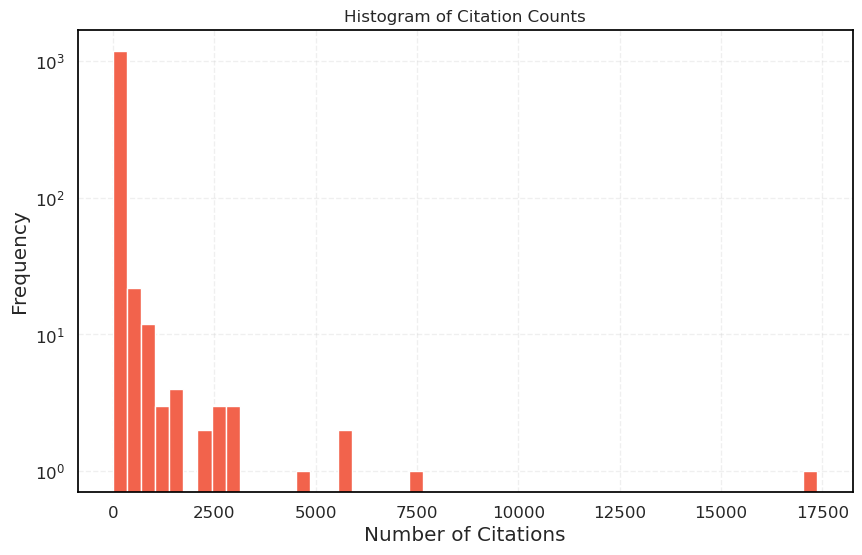

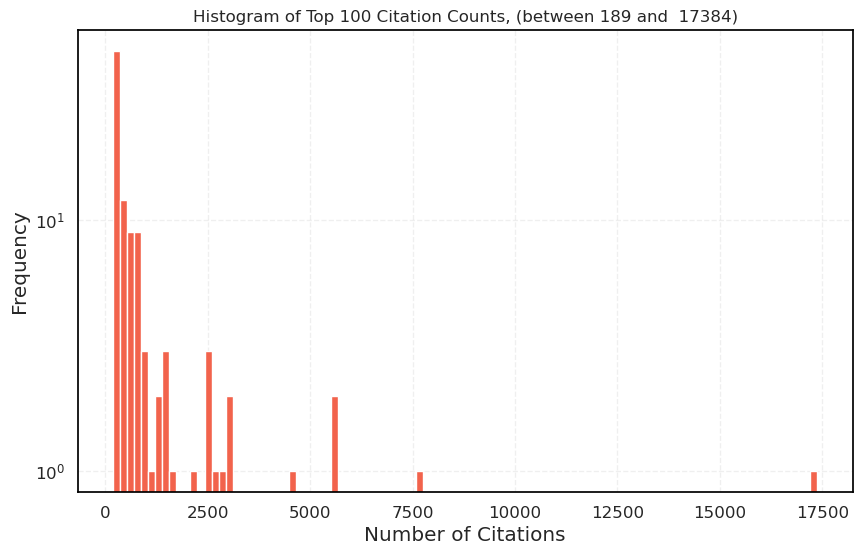

In [88]:
# citation counts for each tool
citation_counts = {tool['name']: tool['nr_citations'] for tool in loaded_graph.vs}
citation_values = list(citation_counts.values())

# TODO subfiugures
# all citation counts
plt.hist(citation_values, bins=50)
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Citation Counts')
plt.show()

# Sorting citations in descending order to get the top 100 most cited tools
sorted_citation_counts = dict(sorted(citation_counts.items(), key=lambda item: item[1], reverse=True))
top_citation_counts = list(sorted_citation_counts.values())[0:100]

# Plotting histogram of the top 100 citation counts
plt.hist(top_citation_counts, bins=100)
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title(f'Histogram of Top 100 Citation Counts, (between {min(top_citation_counts)} and  {max(top_citation_counts)})')
plt.show()

# Loading a graph to analyse the distribution of edge weights


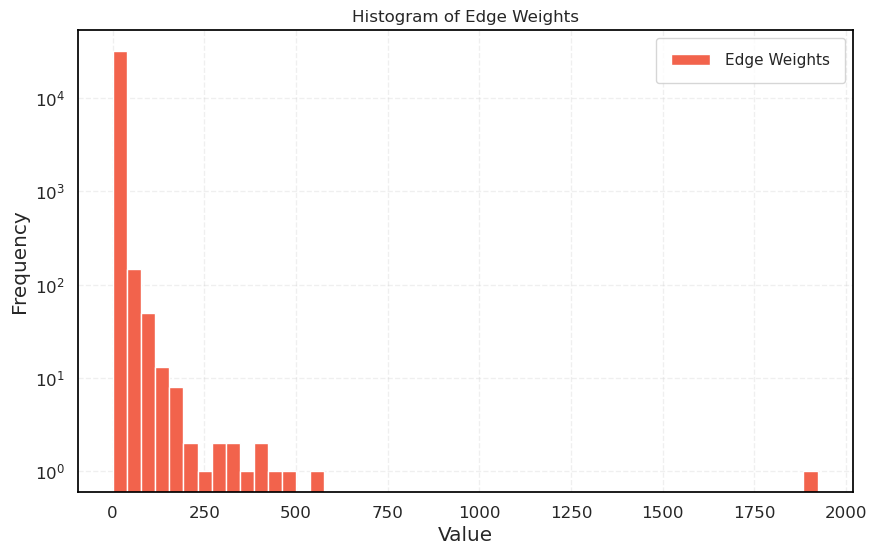

8.0


In [9]:
edge_weights = loaded_graph.es['weight']

plt.hist(edge_weights, bins=50,label='Edge Weights')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Edge Weights')
plt.legend(loc='upper right')
plt.show()

print(np.percentile(edge_weights, 95))

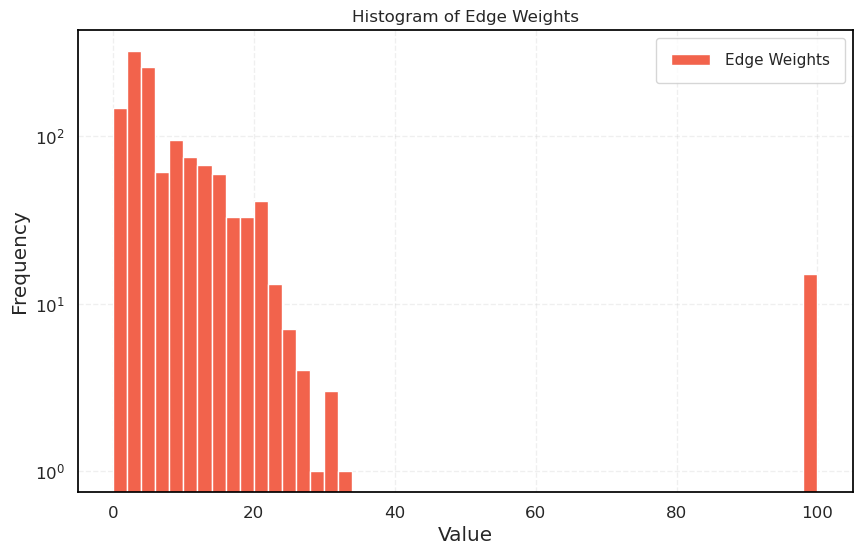

In [90]:
ages = loaded_graph.vs['age']

plt.hist(ages, bins=50, label='Edge Weights')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Edge Weights')
plt.legend(loc='upper right')
plt.show()

#TODO: here is where we get the 

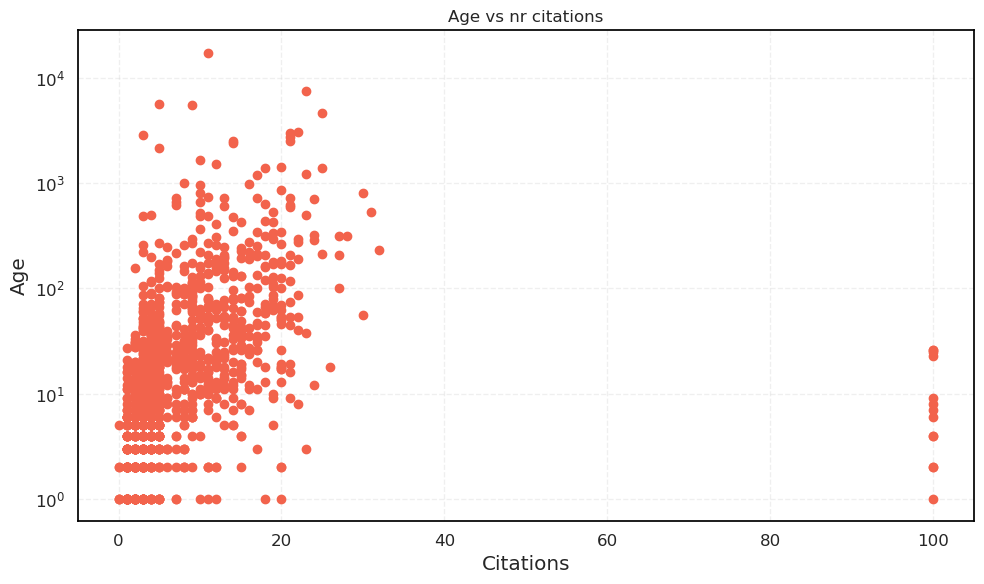

In [91]:
citations = loaded_graph.vs['nr_citations']

plt.scatter(ages, citations)
plt.title('Age vs nr citations')
plt.xlabel('Citations')
plt.ylabel('Age')
plt.yscale('log')
# plt.xscale('log')
plt.tight_layout()
plt.show()


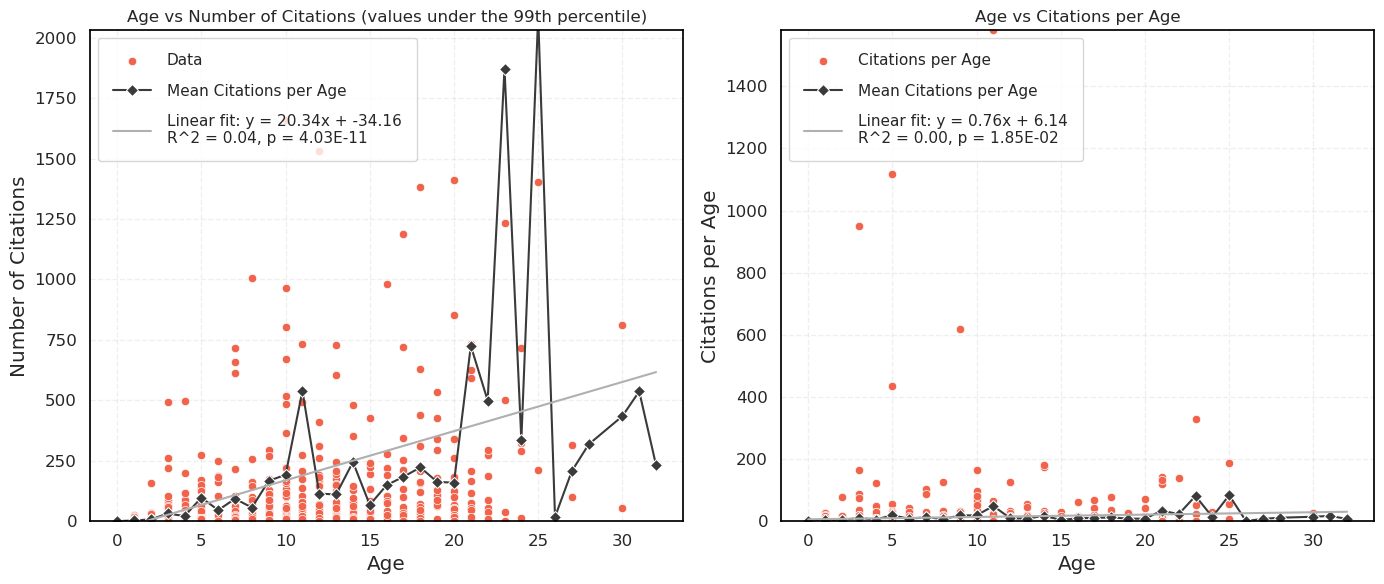

In [99]:
# Filter out ages 50 or above
filtered_data = [(age, citation) for age, citation in zip(ages, citations) if age < 50]
ages_filtered, citations_filtered = zip(*filtered_data)

slope, intercept, r_value, p_value, std_err = linregress(ages_filtered, citations_filtered)
line = slope * np.array(ages_filtered) + intercept

# Mean citations
data = pd.DataFrame({'age': ages_filtered, 'citation': citations_filtered})
mean_citations = data.groupby('age')['citation'].mean().reset_index()

# Calculate citations divided by age to compare the og with 
citations_divided_by_age = [citation / age if age > 0 else citation for citation, age in zip(citations_filtered, ages_filtered)]

slope_div, intercept_div, r_value_div, p_value_div, std_err_div = linregress(ages_filtered, citations_divided_by_age)
line_div = slope_div * np.array(ages_filtered) + intercept_div

data_div = pd.DataFrame({'age': ages_filtered, 'citation_div': citations_divided_by_age})
mean_citations_div = data_div.groupby('age')['citation_div'].mean().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=ages_filtered, y=citations_filtered, ax=axes[0], label='Data', color=palette[0])
sns.lineplot(x=mean_citations['age'], y=mean_citations['citation'], ax=axes[0], marker='D', label='Mean Citations per Age', color=palette[1])
sns.lineplot(x=ages_filtered, y=line, ax=axes[0], label=f'Linear fit: y = {slope:.2f}x + {intercept:.2f}\n'
                                                f'R^2 = {r_value**2:.2f}, p = {p_value:.2E}', color=palette[2])
axes[0].set_title('Age vs Number of Citations (values under the 99th percentile)')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Number of Citations')
axes[0].set_ylim(bottom=0, top=np.percentile(citations, 99))  # Cutting off the top to see the line better
axes[0].legend()

sns.scatterplot(x=ages_filtered, y=citations_divided_by_age, ax=axes[1], label='Citations per Age', color=palette[0])
sns.lineplot(x=mean_citations_div['age'], y=mean_citations_div['citation_div'], ax=axes[1], marker='D', label='Mean Citations per Age', color=palette[1])
sns.lineplot(x=ages_filtered, y=line_div, ax=axes[1], label=f'Linear fit: y = {slope_div:.2f}x + {intercept_div:.2f}\n'
                                                f'R^2 = {r_value_div**2:.2f}, p = {p_value_div:.2E}', color=palette[2])
axes[1].set_title('Age vs Citations per Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Citations per Age')
axes[1].set_ylim(bottom=0, top=np.nanmax(citations_divided_by_age))  # Set limit based on data
axes[1].legend()

plt.tight_layout()
plt.show()


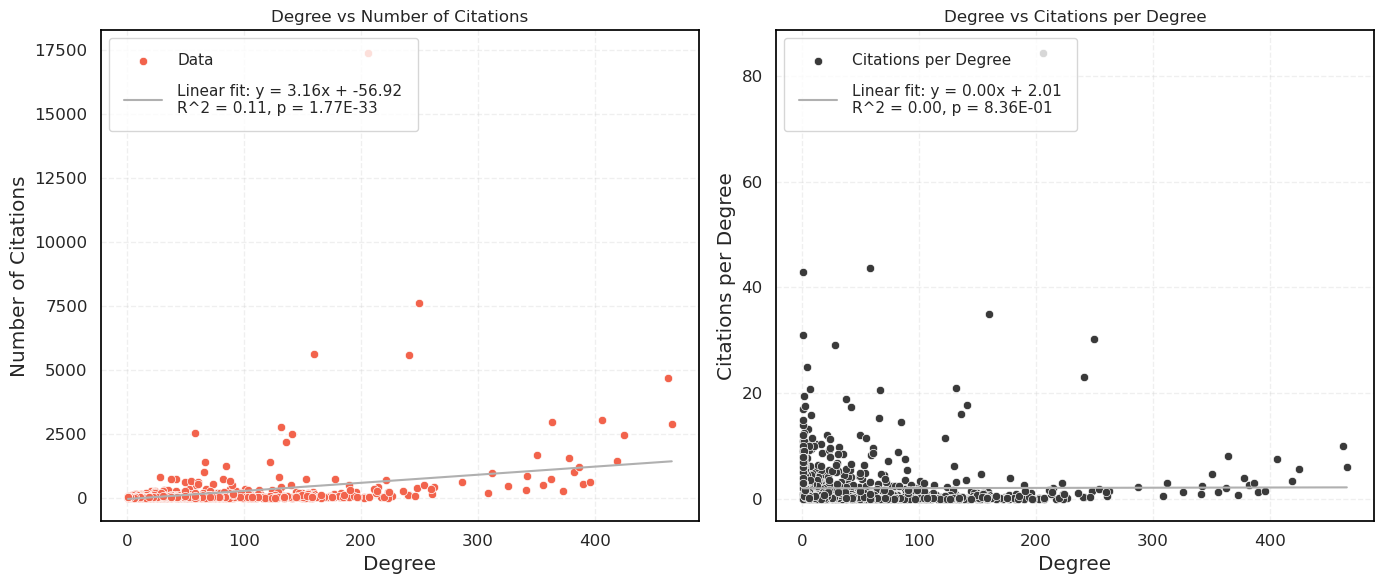

In [101]:
# now same thing for degrees
degrees = [vs.degree() for vs in loaded_graph.vs]

slope, intercept, r_value, p_value, std_err = linregress(degrees, citations)
line = slope * np.array(degrees) + intercept

# Calculate citations divided by degrees to compare with 
citations_divided_by_degrees = [citation / degree if degree > 0 else citation for citation, degree in zip(citations, degrees)]

slope_div, intercept_div, r_value_div, p_value_div, std_err_div = linregress(degrees, citations_divided_by_degrees)
line_div = slope_div * np.array(degrees) + intercept_div

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=degrees, y=citations, ax=axes[0], label='Data', color=palette[0])
sns.lineplot(x=degrees, y=line, ax=axes[0], label=f'Linear fit: y = {slope:.2f}x + {intercept:.2f}\n'
                                                f'R^2 = {r_value**2:.2f}, p = {p_value:.2E}', color=palette[2])
axes[0].set_title('Degree vs Number of Citations')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Number of Citations')
axes[0].legend()

sns.scatterplot(x=degrees, y=citations_divided_by_degrees, ax=axes[1], label='Citations per Degree', color=palette[1])
sns.lineplot(x=degrees, y=line_div, ax=axes[1], label=f'Linear fit: y = {slope_div:.2f}x + {intercept_div:.2f}\n'
                                                f'R^2 = {r_value_div**2:.2f}, p = {p_value_div:.2E}', color=palette[2])
axes[1].set_title('Degree vs Citations per Degree')
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Citations per Degree')
axes[1].legend()

plt.tight_layout()
plt.show()


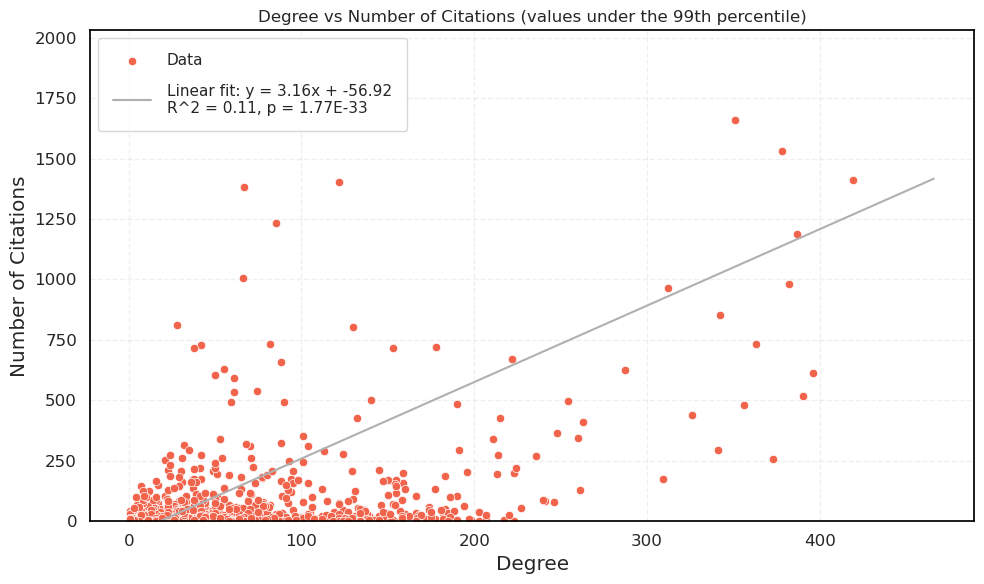

In [80]:
degrees = [vs.degree() for vs in loaded_graph.vs]

# Perform linear regression to get the approximate line
slope, intercept, r_value, p_value, std_err = linregress(degrees, citations)
line = slope * np.array(degrees) + intercept

data = pd.DataFrame({'degree': degrees, 'citation': citations})
# mean_citations = data.groupby('degree')['citation'].mean().reset_index()



sns.scatterplot(x=degrees, y=citations, label='Data', color=palette[0])
# sns.lineplot(x=mean_citations['degree'], y=mean_citations['citation'], marker='D', label='Mean Citations per Degree', color=palette[1])
sns.lineplot(x=degrees, y=line, label=f'Linear fit: y = {slope:.2f}x + {intercept:.2f}\n'
                                                f'R^2 = {r_value**2:.2f}, p = {p_value:.2E}', color=palette[2])
plt.title('Degree vs Number of Citations (values under the 99th percentile)')
plt.xlabel('Degree')
plt.ylabel('Number of Citations')
plt.ylim(bottom=0, top=np.percentile(citations, 99))  # Cutting off the top to see the line better
plt.legend()
plt.tight_layout()

# Show plot
plt.show()


# Stat graveyard

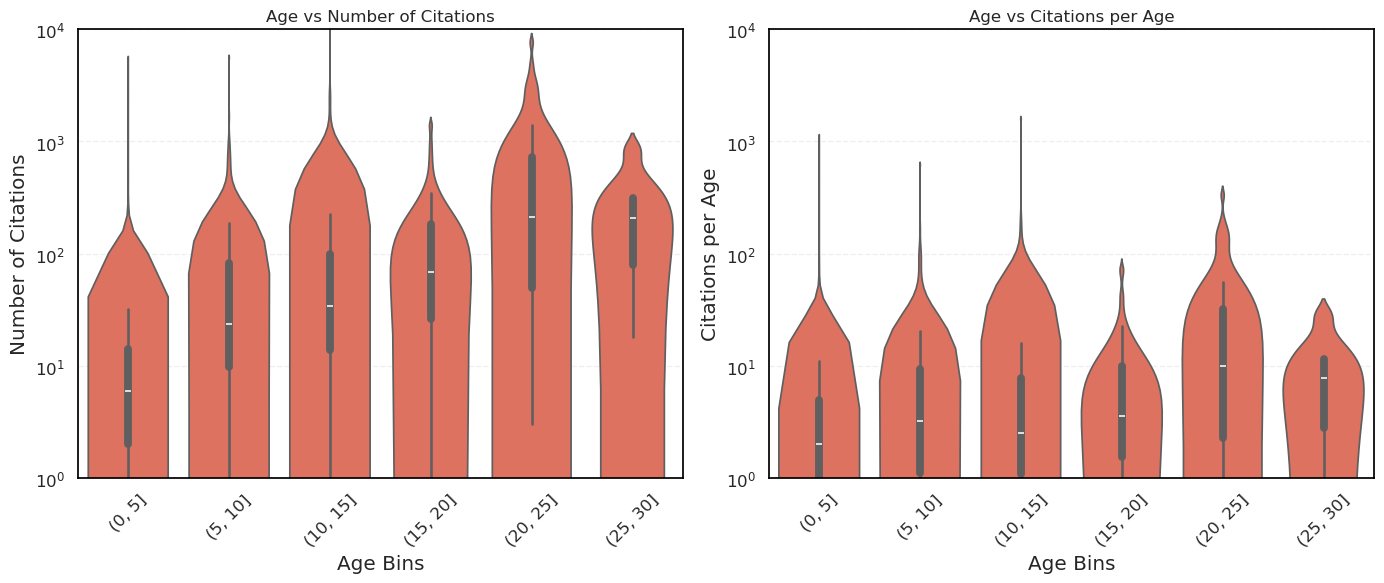

In [107]:
# Create a DataFrame
data = pd.DataFrame({'ages': ages, 'citations': citations})
data['citations_div_by_age'] = data['citations'] / data['ages']

bins = np.arange(0, 35, 5)
data['age_bins'] = pd.cut(data['ages'], bins)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(x='age_bins', y='citations', data=data, ax=axes[0], density_norm='width')
axes[0].set_title('Age vs Number of Citations')
axes[0].set_xlabel('Age Bins')
axes[0].set_ylabel('Number of Citations')
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', rotation=45)

sns.violinplot(x='age_bins', y='citations_div_by_age', data=data, ax=axes[1], density_norm='width')
axes[1].set_title('Age vs Citations per Age')
axes[1].set_xlabel('Age Bins')
axes[1].set_ylabel('Citations per Age')
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', rotation=45)

# Synchronize y-axis limits
y_lim = [1, 10000]
axes[0].set_ylim(y_lim)
axes[1].set_ylim(y_lim)

plt.tight_layout()
plt.show()


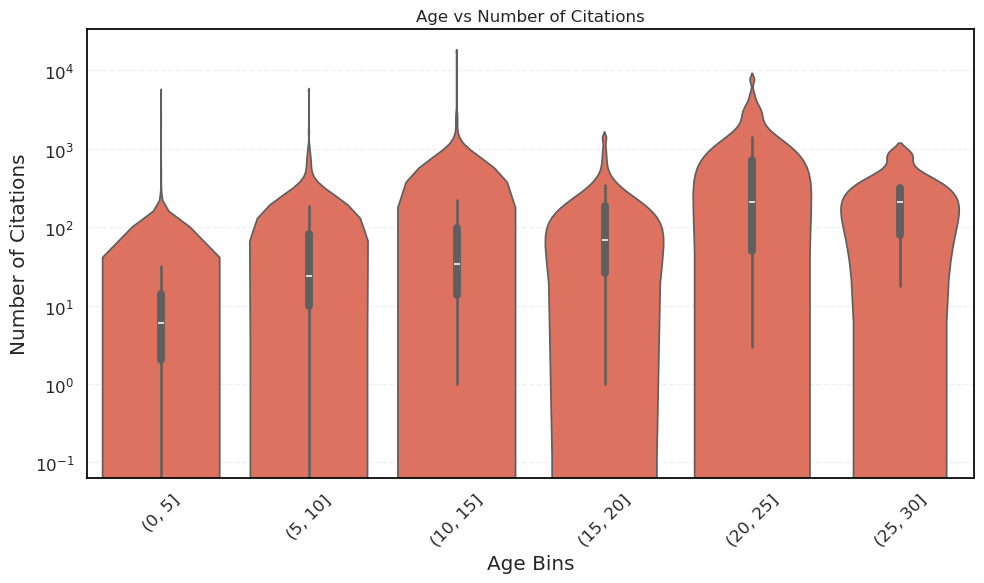

In [102]:
# This did nto turn out very well
# Create a DataFrame for easier manipulation
data = pd.DataFrame({'ages': ages, 'citations': citations})

# Check for negative values
if (data['citations'] < 0).any():
    print("Warning: There are negative values in the citations data.")

# Bin ages into intervals
bins = np.arange(0, 35, 5) 
data['age_bins'] = pd.cut(data['ages'], bins)

plt.figure(figsize=(10, 6))
sns.violinplot(x='age_bins', y='citations', data=data, density_norm='width')  # cut=0 prevents KDE from extending beyond data range

plt.title('Age vs Number of Citations')
plt.xlabel('Age Bins')
plt.ylabel('Number of Citations')
plt.yscale('log')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
